In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from scipy.optimize import least_squares
import time

from binarypredictor import BinaryPredictor
from binarypredictor.dataset import FunctionPairDataset
from binarypredictor.net import DerivativeNet, TangentNet
from binarypredictor.cm import base_function, first_derivative, second_derivative

In [2]:
bp = BinaryPredictor(net_1='net_1.pth', net_2='net_2.pth')

# AuAg

net_1.pth \
net_2.pth

In [46]:
%%timeit -n 20
R = 8.3143

gf = lambda t: 3815.93 + 109.3029 * t - 1.044523e-20 * t ** 7 - (-7209.5 + 118.2007 * t)
gg = lambda t: -3352 + 215.88 * t - 3.5899325e-21 * t ** 7 - (-15745 + 225.14 * t)

real_data = pd.read_csv('auag.txt', delimiter='\t')
t_range = real_data['LIQUID + FCC_A1']

f = lambda x, t: (1 - x) * gf(t) + x * gg(t) + R * t * ((1 - x) * torch.log(1 - x) + x * torch.log(x)) + (1 - x) * x * (-16402 + 1.14 * t)
g = lambda x, t: R * t * ((1 - x) * torch.log(1 - x) + x * torch.log(x)) + (1 - x) * x * (-15599)

df = lambda x, t: -16402 - gf(t) + gg(t) + 1.14 * t + 32804 * x - 2.28 * t * x - R * t * torch.log(1 - x) + R * t * torch.log(x)
dg = lambda x, t: 15599 * (-1 + 2 * x) - R * t * torch.log(1 - x) + R * t * torch.log(x)

xf_eq, xg_eq, ts = bp.get_phase_diagram(t_range, f, g, df, dg, plot=False, threshold=0.1, max_threshold=0.3)

2.36 s ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


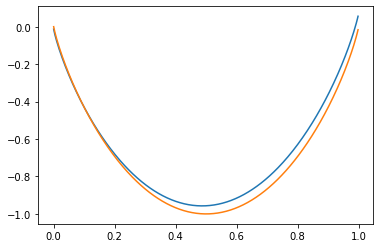

In [4]:
x = torch.arange(1e-10, 1., step=1/500)

t = 1250

scale = torch.max(torch.max(abs(f(x, t))), torch.max(abs(g(x, t))))

plt.plot(x, f(x, t)/scale)
plt.plot(x, g(x, t)/scale)

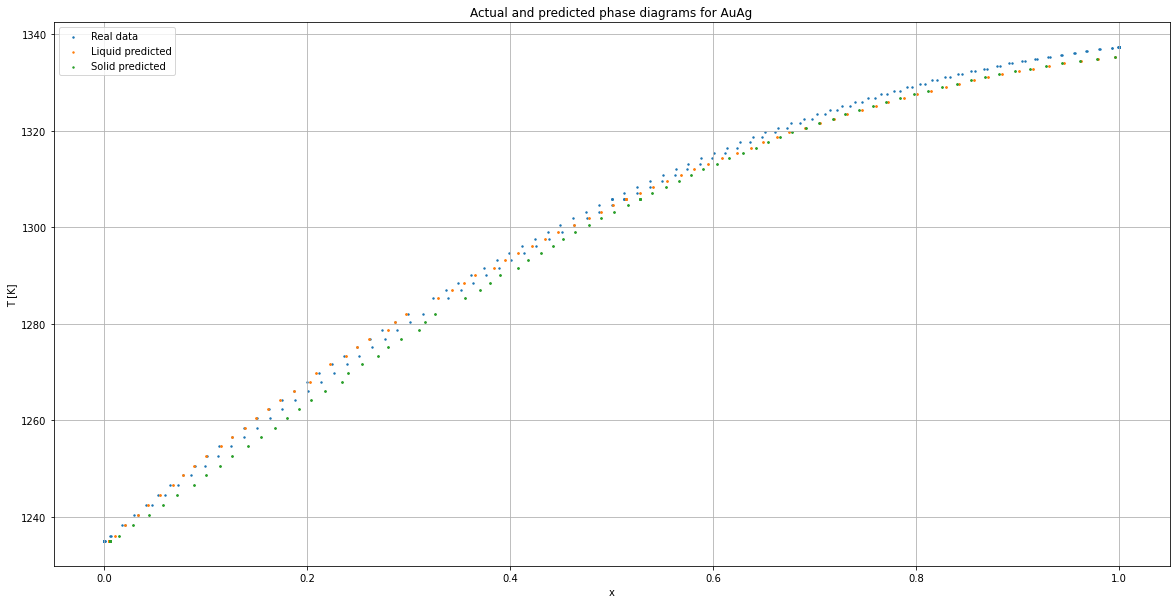

In [6]:
x_fs_ = []
for x_ in xf_eq: 
    x_fs_.append(x_[0])
    
x_gs_ = []
for x_ in xg_eq: 
    x_gs_.append(x_[0])
    
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(real_data['Mole fraction Au'], real_data['LIQUID + FCC_A1'], s=s, label='Real data')
ax.scatter(x_fs_, ts, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts, s=s, label='Solid predicted')
ax.grid()
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Actual and predicted phase diagrams for AuAg')
ax.legend()

In [7]:
r_x = []

for x_, r_t in zip(real_data['Mole fraction Au'], real_data['LIQUID + FCC_A1']):
    if r_t in ts:
        r_x.append(x_)
        
x_fs_t = torch.tensor(x_fs_)
r_x_t = torch.tensor(r_x)

print('Mean error: ', nn.L1Loss()(x_fs_t, r_x_t).item())
print('Mean squared error: ', nn.MSELoss()(x_fs_t, r_x_t).item())
print('Max deviation: ' , torch.max(abs(x_fs_t - r_x_t)).item())
print('Min deviation: ' , torch.min(abs(x_fs_t - r_x_t)).item())

Mean error:  0.01565570756793022
Mean squared error:  0.0004928208072669804
Max deviation:  0.06612342596054077
Min deviation:  9.797513484954834e-06


In [48]:
%%timeit -n 20

f_eq = []
g_eq = []
funcs = []

x_ = np.arange(1e-10, 1., step=1/(len(t_range)))

for x_t, t in zip(x_, t_range):
    gf = lambda t: 3815.93 + 109.3029 * t - 1.044523e-20 * t ** 7 - (-7209.5 + 118.2007 * t)
    gg = lambda t: -3352 + 215.88 * t - 3.5899325e-21 * t ** 7 - (-15745 + 225.14 * t)
    
    f = lambda x: (1 - x) * gf(t) + x * gg(t) + R * t * ((1 - x) * np.log(1 - x) + x * np.log(x)) + (1 - x) * x * (-16402 + 1.14 * t)
    g = lambda x: R * t * ((1 - x) * np.log(1 - x) + x * np.log(x)) + (1 - x) * x * (-15599)

    df = lambda x: -16402 - gf(t) + gg(t) + 1.14 * t + 32804 * x - 2.28 * t * x - R * t * np.log(1 - x) + R * t * np.log(x)
    dg = lambda x: 15599 * (-1 + 2 * x) - R * t * np.log(1 - x) + R * t * np.log(x)
    
    scale = max(torch.max(abs(f(x))), torch.max(abs(g(x))))
    
    def eqns(x):
        x1, x2 = x[0], x[1]
        eq1 = (df(x1) - dg(x2))/scale
        eq2 = (f(x1) - g(x2) - x1 * df(x1) + x2 * dg(x2))/scale
        return [eq1, eq2]

    x0 = [1e-10, 1.]
    lb = (0, 0)   # lower bounds on x1, x2
    ub = (1, 1)    # upper bounds

    res = least_squares(eqns, x0, bounds=(lb, ub))
    
    if res.success:
        f_eq.append((res.x[0], t))
        g_eq.append((res.x[1], t))
        funcs.append(res.fun)

6.65 s ± 629 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


# Lukas-Petzow-Mager functions

In [3]:
def a(a_sum, a_diff, TM):
    r = 8.314

    a_sum *= TM * r
    a_diff *= TM * r

    a_1 = (a_sum - a_diff) / 2
    a_2 = (a_sum + a_diff) / 2

    return a_1, a_2

In [426]:
x = torch.arange(1e-10, 1., step=1/500)

tm_1, tm_2 = 900, 1100
tm = (tm_1 + tm_2)/2

a_diff = -2
a_sum = 12
a_1, a_2 = a(a_sum, a_diff, tm)
print(a_1, a_2)

k = dict()
k['step'] = 1/500
k['tm1'] = tm_1
k['tm2'] = tm_2
k['tm'] = tm
k['s1'] = 10
k['s2'] = 10
k['a'] = a_1

c = dict()
c['step'] = 1/500
c['tm1'] = tm_1
c['tm2'] = tm_2
c['tm'] = tm
c['s1'] = 0
c['s2'] = 0
c['a'] = a_2

58198.0 41570.0


In [427]:
x = torch.arange(1e-10, 1., step=1/500)
t_range = range(0, 1500)

In [428]:
#t_range = range(1000, 1001)

f = lambda x, t: base_function(**k, x=x, t=t)
g = lambda x, t: base_function(**c, x=x, t=t)

df = lambda x, t: first_derivative(**k, x=x, t=t)
dg = lambda x, t: first_derivative(**c, x=x, t=t)

tensor([28])
tensor([394.2809])


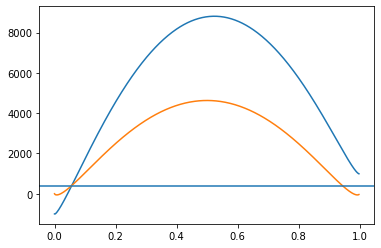

In [429]:
diff = f(x, t) - g(x, t)
sig = torch.sign(diff)
t0 = torch.where(torch.diff(sig) != 0)[0]
print(t0)

x0 = x[t0]
y0 = f(x0, t)

plt.plot(x, f(x, t))
plt.plot(x, g(x, t))
print(y0)
for yy in y0:
    plt.axhline(yy)

In [430]:
#%%timeit -n 20

xf_eq, xg_eq, ts = bp.get_phase_diagram(t_range, f, g, df, dg, plot=False, threshold=.3, max_threshold=2.)

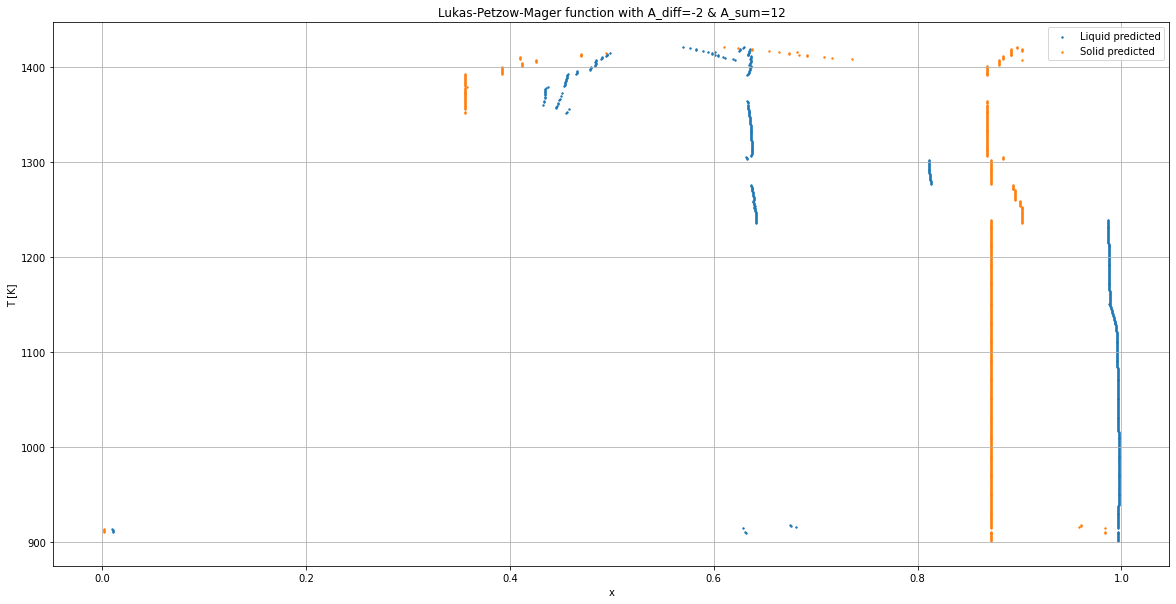

In [431]:
x_fs_ = []
x_gs_ = []
ts_ = []
for i, xs in enumerate(zip(xf_eq, xg_eq)): 
    for xf_, xg_ in zip(xs[0], xs[1]):
        x_fs_.append(xf_)
        x_gs_.append(xg_)
        ts_.append(ts[i])
            
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(x_fs_, ts_, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts_, s=s, label='Solid predicted')
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title(f'Lukas-Petzow-Mager function with A_diff={a_diff} & A_sum={a_sum}')
plt.grid()
ax.legend()

In [22]:
#%%timeit -n 20

f_eq = []
g_eq = []
funcs = []

x_ = np.arange(1e-10, 1., step=1/(len(t_range)))

for x_t, t in zip(x_, t_range):
    f_ = lambda x: base_function(**k, x=torch.tensor(x), t=t)
    g_ = lambda x: base_function(**c, x=torch.tensor(x), t=t)

    df_ = lambda x: first_derivative(**k, x=torch.tensor(x), t=t)
    dg_ = lambda x: first_derivative(**c, x=torch.tensor(x), t=t)
    
    scale = max(torch.max(abs(f_(x))), torch.max(abs(g_(x))))
    
    def eqns(x):
        x1, x2 = x[0], x[1]
        eq1 = (df_(x1) - dg_(x2))/scale
        eq2 = (f_(x1) - g_(x2) - x1 * df_(x1) + x2 * dg_(x2))/scale
        return [eq1, eq2]

    x0 = [1e-10, 1.]
    lb = (0, 0)   # lower bounds on x1, x2
    ub = (1, 1)    # upper bounds

    res = least_squares(eqns, x0, bounds=(lb, ub))
    
    if res.success:
        f_eq.append((res.x[0], t))
        g_eq.append((res.x[1], t))
        funcs.append(res.fun)

<magic-timeit>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
<magic-timeit>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


24.8 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [ ]:
x_fs_ = []
x_gs_ = []
ts_ = []
for i, xs in enumerate(zip(xf_eq, xg_eq)): 
    for xf_, xg_ in zip(xs[0], xs[1]):
        x_fs_.append(xf_)
        x_gs_.append(xg_)
        ts_.append(ts[i])
            
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
s = 2
ax.scatter(x_fs_, ts_, s=s, label='Liquid predicted')
ax.scatter(x_gs_, ts_, s=s, label='Solid predicted')
plt.xlabel('x')
plt.ylabel('T [K]')
plt.title('Lukas-Petzow-Mager function with A_diff=0 & A_sum=0')
plt.grid()
ax.legend()